In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import models, datasets
import torchvision.transforms as transforms
from torch import optim
import cv2, glob, numpy as np, pandas as pd
from glob import glob
from PIL import Image 
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [5]:
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

In [6]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')

        # first 500 data
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import seed, shuffle; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]

    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        im = cv2.imread(f)
        target = self.targets[ix]
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im/255)
        im = im.permute(2, 0, 1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [7]:
data = CatsDogs(train_data_dir)
img, lb = data[100]

tensor([0.], device='cuda:0')


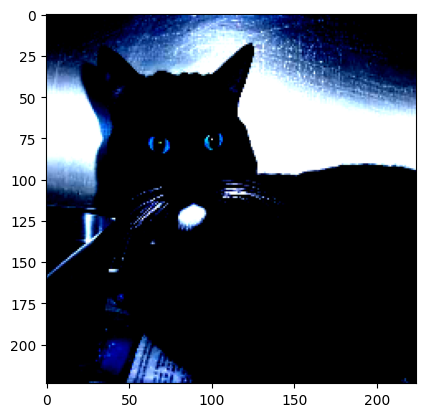

In [8]:
import matplotlib.pyplot as plt
print(lb)
plt.imshow(img.permute(1, 2, 0).cpu())

In [17]:
def get_model():
    model = models.vgg16(pretrained = True)
    # specify pretrained = True ==> load the weights used in the pretrained model

    # Set the weights not trainable 
    for param in model.parameters():
        param.requires_grad = False

    # Change the avgpool submodule
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    # Change the classifier submodule
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid()
        )

    # loss
    loss_fn = nn.BCELoss()

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    return model.to(device), loss_fn, optimizer

In [19]:
!pip install torch_summary
from torchsummary import summary

model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [20]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [21]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [24]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_batch_loss = loss_fn(prediction, y)
    return val_batch_loss.item()

In [22]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [23]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [26]:
# training
train_losses = []
train_accuracies, val_accuracies = [], []

n_epochs = 5
for epoch in range(n_epochs):

    epoch_train_losses = []
    epoch_train_accuracies, epoch_val_accuracies = [], []

    for ix, (x, y) in enumerate(iter(trn_dl)):
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_train_losses.append(batch_loss)
    epoch_train_loss = np.array(epoch_train_losses).mean()

    for ix, (x, y) in enumerate(iter(trn_dl)):
        is_correct = accuracy(x, y, model)
        epoch_train_accuracies.extend(is_correct)
    epoch_train_accuracy = np.array(epoch_train_accuracies).mean()

    for ix, (x, y) in enumerate(iter(val_dl)):
        is_correct = accuracy(x, y, model)
        epoch_val_accuracies.extend(is_correct)
    epoch_val_accuracy = np.array(epoch_val_accuracies).mean()

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    val_accuracies.append(epoch_val_accuracy)

    print('epoch ' + str(epoch+1) + 'DONE')

epoch 1DONE
epoch 2DONE
epoch 3DONE
epoch 4DONE
epoch 5DONE


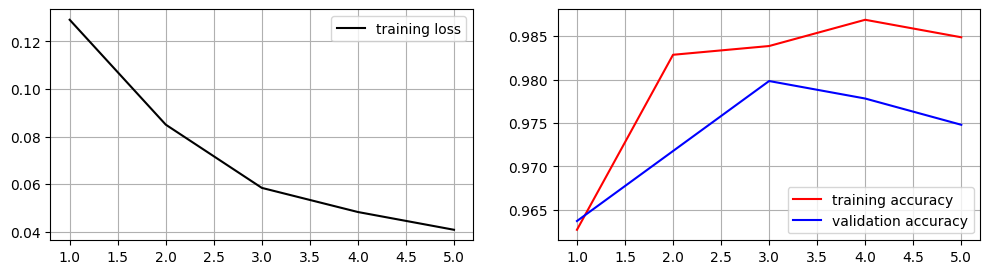

In [32]:
fig = plt.figure(figsize = (12, 3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, n_epochs)+1, train_losses, label = 'training loss', c = 'black')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, n_epochs)+1, train_accuracies, label = 'training accuracy', c = 'red')
plt.plot(np.arange(0, n_epochs)+1, val_accuracies, label = 'validation accuracy', c = 'blue')
plt.grid(True)
plt.legend()